# 3D Brain Tumor Segmentation with Swin UNETR (BraTS 21 Challenge)


This tutorial uses the [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) [1,2] model for the task of brain tumor segmentation using the [BraTS 21](http://braintumorsegmentation.org/) challenge dataset [3,4,5,6]. Swin UNETR ranked among top-performing models in the BraTS 21 validation phase. The architecture of Swin UNETR is demonstrated below

![swin_brats](../figures/swin_brats21.png)

The following features are included in this tutorial:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly rotate across each axes for data augmentation.
1. Randomly adjust the intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. Swin UNETR model, Dice loss function, Mean Dice metric for brain tumor segmentation task.


### Tumor Characteristics

The sub-regions considered for evaluation in the BraTS 21 challenge are the "enhancing tumor" (ET), the "tumor core" (TC), and the "whole tumor" (WT). The ET is described by areas that show hyper-intensity in T1Gd when compared to T1, but also when compared to “healthy” white matter in T1Gd. The TC describes the bulk of the tumor, which is what is typically resected. The TC entails the ET, as well as the necrotic (NCR) parts of the tumor. The appearance of NCR is typically hypo-intense in T1-Gd when compared to T1. The WT describes the complete extent of the disease, as it entails the TC and the peritumoral edematous/invaded tissue (ED), which is typically depicted by the hyper-intense signal in FLAIR [[BraTS 21]](http://braintumorsegmentation.org/).

The provided segmentation labels have values of 1 for NCR, 2 for ED, 4 for ET, and 0 for everything else.

![image](../figures/fig_brats21.png)

Figure from [Baid et al.](https://arxiv.org/pdf/2107.02314v1.pdf) [3]



## References


If you find this tutorial helpful, please consider citing [1] and [2]:

[1]: Hatamizadeh, A., Nath, V., Tang, Y., Yang, D., Roth, H. and Xu, D., 2022. Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images. arXiv preprint arXiv:2201.01266.

[2]: Tang, Y., Yang, D., Li, W., Roth, H.R., Landman, B., Xu, D., Nath, V. and Hatamizadeh, A., 2022. Self-supervised pre-training of swin transformers for 3d medical image analysis. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 20730-20740).


### BraTS Dataset References

[3] U.Baid, et al., The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification, arXiv:2107.02314, 2021.

[4] B. H. Menze, A. Jakab, S. Bauer, J. Kalpathy-Cramer, K. Farahani, J. Kirby, et al. "The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)", IEEE Transactions on Medical Imaging 34(10), 1993-2024 (2015) DOI: 10.1109/TMI.2014.2377694

[5] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J.S. Kirby, et al., "Advancing The Cancer Genome Atlas glioma MRI collections with expert segmentation labels and radiomic features", Nature Scientific Data, 4:170117 (2017) DOI: 10.1038/sdata.2017.117

[6] S. Bakas, H. Akbari, A. Sotiras, M. Bilello, M. Rozycki, J. Kirby, et al., "Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-GBM collection", The Cancer Imaging Archive, 2017. DOI: 10.7937/K9/TCIA.2017.KLXWJJ1Q

## Swin UNETR Model

The inputs to [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) are 3D multi-modal MRI images with 4 channels.
The patch partition block creates non-overlapping patches of the input data and projects them into embedding tokens with a resolution of 128x128x128.
The projected tokens are then encoded by using a 3D [Swin Transformer](https://openaccess.thecvf.com/content/ICCV2021/papers/Liu_Swin_Transformer_Hierarchical_Vision_Transformer_Using_Shifted_Windows_ICCV_2021_paper.pdf) in which the self-attention is computed within local windows.
The interaction between different windows is obtained by using 3D window shifting as illustrated below. 

![image](../figures/shift_patch.png)

The transformer-based encoder is connected to a CNN-decoder via skip connection at multiple resolutions.
The segmentation output consists of 3 output channels corresponding to ET, WT, and TC sub-regions and is computed by using a 1x1x1 convolutional layer followed by Sigmoid activation function.


## Setup environment

In [1]:
import os

# Set the environment variable to allow duplicate OpenMP libraries
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
#!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]
!python -c "import matplotlib" || pip install -q matplotlib
!pip install gdown
!pip install nibabel
%matplotlib inline

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Setup imports

In [3]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

from torch.utils.tensorboard import SummaryWriter

import torch


print_config()

MONAI version: 1.6.dev2543
Numpy version: 2.3.3
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: bc5f3d1c1abae1389cd0e3d1a0bf3ff56e7f394d
MONAI __file__: /scr/user/<username>/monai/lib/python3.13/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.20.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.1.2
pandas version: 2.3.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/i

## Download Dataset from GDrive

In [4]:
import os
import gdown
import zipfile

# Google Drive file ID
file_id = '1FVgmSx_b7HjJF3_3mN71WJRPoqJiiY69'

root_dir = os.getcwd()
print(f"Using current directory as root: {root_dir}")

compressed_file = os.path.join(root_dir, "TrainingData.zip")
data_root_dir = os.path.join(root_dir, "TrainingData")
final_data_dir = os.path.join(data_root_dir, "TrainingData")
print(f"Using current dataset directory: {final_data_dir}")

# Check if the final data directory already exists
if not os.path.exists(final_data_dir):
    print("Downloading...")
    gdown.download(f'https://drive.google.com/uc?id={file_id}', compressed_file, quiet=False)
    print("Download complete.")

    print("Unzipping...")
    try:
        # Extract the contents to the 'Task09_Spleen' folder, not the nested one
        with zipfile.ZipFile(compressed_file, 'r') as zip_ref:
            zip_ref.extractall(data_root_dir)
        print("Unzipping complete.")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is corrupted or not a valid zip file.")
        if os.path.exists(compressed_file):
            os.remove(compressed_file)
else:
    print("Data directory already exists. Skipping download and extraction.")

Using current directory as root: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/3_Brain_Tumor_Segmentation_3D
Using current dataset directory: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/3_Brain_Tumor_Segmentation_3D/TrainingData/TrainingData
Data directory already exists. Skipping download and extraction.


## Setup average meter, fold reader, checkpoint saver

In [5]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Setup dataloader

In [6]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
                allow_smaller=True,
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    return train_loader, val_loader

## Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial. 

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1. 

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [31]:
data_dir = final_data_dir
print(f"Setting MONAI data_dir to: {data_dir}")

json_list = os.path.join(data_dir,"brats21_folds_demo.json")
print(f"JSON List Directory: {json_list}")

roi = (96, 96, 96)
batch_size = 2
sw_batch_size = 2
val_every = 5
infer_overlap = 0.25
fold = 1
max_epochs = 5

# roi = (128, 128, 128)
# batch_size = 2
# sw_batch_size = 2
# fold = 1
# infer_overlap = 0.5
# max_epochs = 5
# val_every = 2
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

Setting MONAI data_dir to: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/3_Brain_Tumor_Segmentation_3D/TrainingData/TrainingData
JSON List Directory: /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/3_Brain_Tumor_Segmentation_3D/TrainingData/TrainingData/brats21_folds_demo.json


## Check data shape and visualize

image shape: (240, 240, 155), label shape: (240, 240, 155)


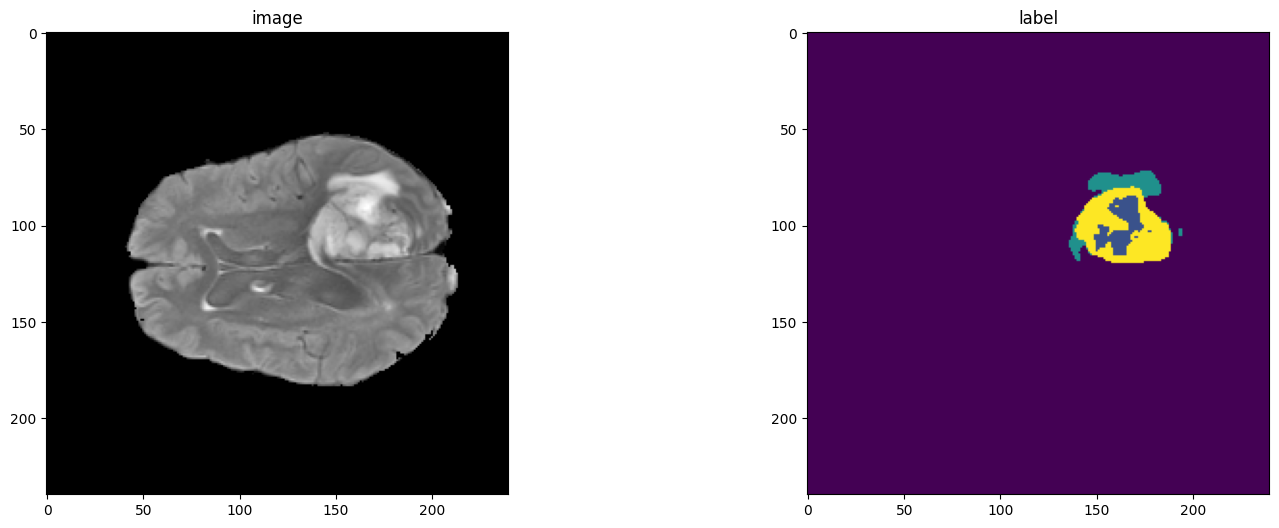

In [23]:
img_add = os.path.join(data_dir, "TrainingData/BraTS2021_00579/BraTS2021_00579_flair.nii.gz")
label_add = os.path.join(data_dir, "TrainingData/BraTS2021_00579/BraTS2021_00579_seg.nii.gz")

# print(f"Image Add:{img_add}")
# print(f"Label Add:{label_add}")

img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

## Check VRAM Usage

In [24]:
# Check initial VRAM usage
initial_vram = torch.cuda.memory_allocated()
print(f"Initial VRAM usage: {initial_vram / 1024**2:.2f} MB")

!nvidia-smi

Initial VRAM usage: 1266.25 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 10 08:12:35 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              55W / 400W |     87MiB / 81920MiB |     N/A      Default |
|                

## Create Swin UNETR model

In this section, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.  

In [25]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device used: {device}")

model = SwinUNETR(
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

Device used: cuda


## Optimizer and loss function

In [26]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Create a SummaryWriter instance
writer = SummaryWriter()

model_vram = torch.cuda.memory_allocated()
print(f"VRAM after model creation: {model_vram / 1024**2:.2f} MB")

# Reset max memory tracking
torch.cuda.reset_peak_memory_stats()

VRAM after model creation: 1035.23 MB


## Define Train and Validation Epoch

In [27]:
def train_epoch(model, loader, optimizer, epoch, loss_func, writer=None):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
        
        if writer:
            writer.add_scalar("Training/Loss", run_loss.avg, epoch)
        
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
    writer=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            val_avg_acc = np.mean(run_acc.avg)
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()
        
            if writer:
                writer.add_scalar("Validation/Dice_TC", dice_tc, epoch)
                writer.add_scalar("Validation/Dice_WT", dice_wt, epoch)
                writer.add_scalar("Validation/Dice_ET", dice_et, epoch)
                writer.add_scalar("Validation/Dice_Avg", val_avg_acc, epoch)

    return run_acc.avg

## Define Trainer

In [28]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
    writer=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
            writer=writer,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
                writer=writer,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Execute training

In [32]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
    writer=writer,
)

Mon Nov 10 08:21:25 2025 Epoch: 0
Epoch 0/5 0/80 loss: 0.7698 time 28.86s
Epoch 0/5 1/80 loss: 0.7796 time 0.63s
Epoch 0/5 2/80 loss: 0.8185 time 0.62s
Epoch 0/5 3/80 loss: 0.8512 time 0.62s
Epoch 0/5 4/80 loss: 0.8737 time 0.62s
Epoch 0/5 5/80 loss: 0.8514 time 0.62s
Epoch 0/5 6/80 loss: 0.8559 time 0.62s
Epoch 0/5 7/80 loss: 0.8325 time 0.62s
Epoch 0/5 8/80 loss: 0.8241 time 0.62s
Epoch 0/5 9/80 loss: 0.8339 time 0.62s
Epoch 0/5 10/80 loss: 0.8442 time 0.62s
Epoch 0/5 11/80 loss: 0.8478 time 0.62s
Epoch 0/5 12/80 loss: 0.8552 time 0.62s
Epoch 0/5 13/80 loss: 0.8540 time 0.62s
Epoch 0/5 14/80 loss: 0.8530 time 0.62s
Epoch 0/5 15/80 loss: 0.8520 time 0.62s
Epoch 0/5 16/80 loss: 0.8478 time 0.62s
Epoch 0/5 17/80 loss: 0.8514 time 0.62s
Epoch 0/5 18/80 loss: 0.8483 time 0.62s
Epoch 0/5 19/80 loss: 0.8448 time 0.62s
Epoch 0/5 20/80 loss: 0.8520 time 0.62s
Epoch 0/5 21/80 loss: 0.8530 time 0.62s
Epoch 0/5 22/80 loss: 0.8536 time 0.62s
Epoch 0/5 23/80 loss: 0.8501 time 0.62s
Epoch 0/5 24/80

In [33]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

# Close the SummaryWriter
writer.close()

train completed, best average dice: 0.3429 


## Tensorboard to show the training loss and validation loss

- Vist `http://10.11.132.43:8228/` in the browser for the visualization of the tensorboard.

In [34]:
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir runs --host 0.0.0.0 --port 8228

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Check Final VRAM Usage

In [35]:
final_vram = torch.cuda.max_memory_allocated()
print(f"Final Peak VRAM during training: {final_vram / 1024**2:.2f} MB")

print(f"Current VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

!nvidia-smi

Final Peak VRAM during training: 27668.13 MB
Current VRAM: 1816.44 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 10 08:31:39 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              53W / 400W |     87MiB / 81920MiB |  

### Plot the loss and Dice metric

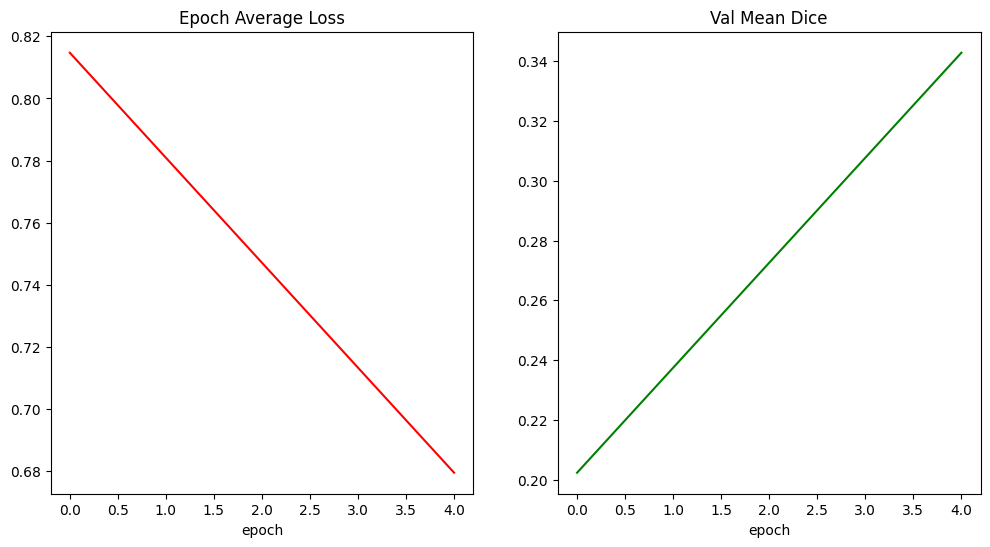

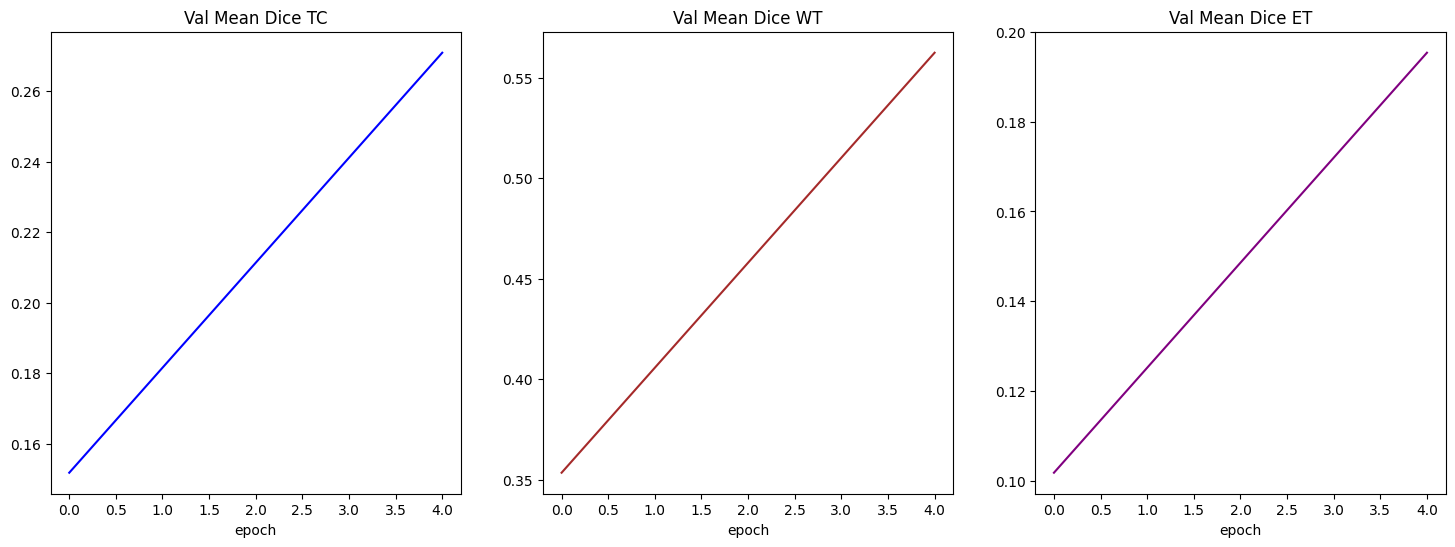

In [36]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

## Create test set dataloader

In [37]:
case_num = "01499"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

## Load the best saved checkpoint and perform inference 

We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label. 

In [38]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"), weights_only=False)["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

## Visualize segmentation output and compare with label

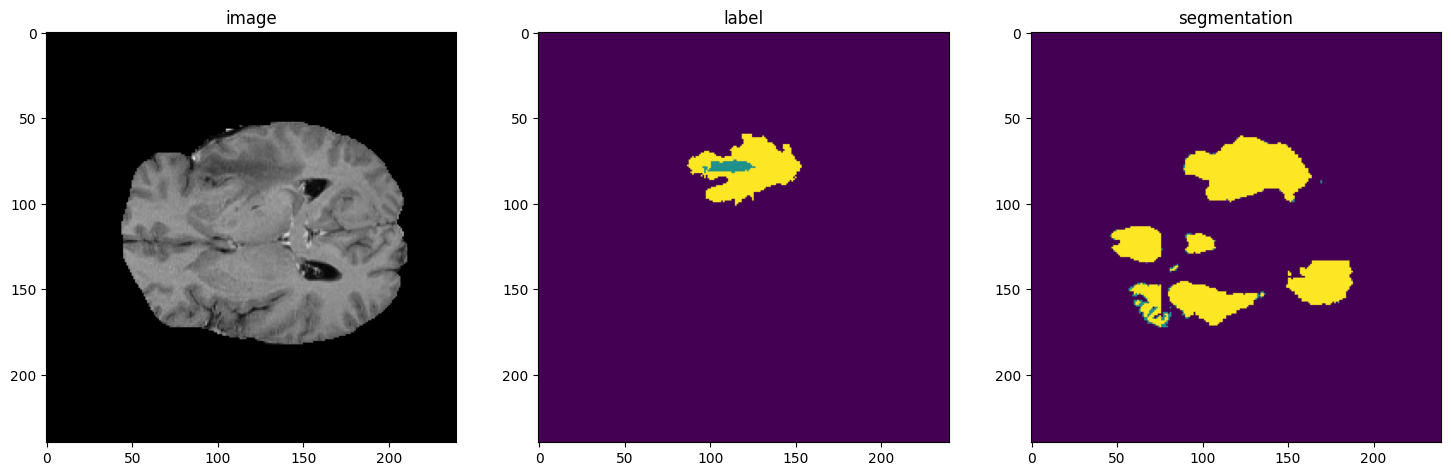

In [39]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()